# Begin the Code and Mount Google Drive to access files

In [1]:
import os

# Comment these lines out if not using google colab
from google.colab import drive
drive.mount('/content/gdrive/')
os.chdir('/content/gdrive/My Drive/LLR_NN')

!ls

Drive already mounted at /content/gdrive/; to attempt to forcibly remount, call drive.mount("/content/gdrive/", force_remount=True).
bpsk_model.json		 data_files_single_snr_fade  llr_bpsk_model_single.h5
bpsk_single.json	 fdeep_model.json	     llr_model.h5
data_files_multiple_snr  keras_export		     result_figures
data_files_single_snr	 llr_bpsk_model.h5


In [0]:
# Can comment the pip install if not using GPU
# Note that commenting this line out if your computer has a GPU will result in slower training times

# comment the %%capture line if not on google colab, this is to supress the output
%%capture
!pip install tensorflow-gpu==2.1.0

## Import Required Libraries

In [0]:
import numpy as np
import scipy.io as sio
import sklearn
import tensorflow as tf
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Input, Dense, Dropout, Embedding, LSTM, MaxPooling1D
from tensorflow.keras.layers import Activation,Conv2D, Flatten, Permute, Cropping2D
from tensorflow.keras.layers import ZeroPadding2D, MaxPooling2D, AveragePooling2D
from tensorflow.keras.layers import BatchNormalization, Reshape
from tensorflow.keras.layers import Conv1D, GRU
from tensorflow.keras.layers import ConvLSTM2D
from tensorflow.keras import regularizers
from tensorflow.keras import optimizers
from tensorflow.keras import initializers
import matplotlib.pyplot as plt

# Load the Data

In [4]:
MODULATION = "16_QAM"
SNR = "1.8"
FADE_VAR = "0.01"
SNR_RANGE_MIN = "0"
SNR_RANGE_MAX = "10"

# Load the training data
X_train_single_SNR = np.genfromtxt("./data_files_single_snr/" + MODULATION + "_X_train_snr_" + SNR + ".csv", delimiter=',')
y_train_single_SNR = np.genfromtxt("./data_files_single_snr/" + MODULATION + "_y_train_snr_" + SNR + ".csv", delimiter=',')
X_train_multiple_SNR = np.genfromtxt("./data_files_multiple_snr/" + MODULATION + "_X_train_snr_range_" + SNR_RANGE_MIN + "_" + SNR_RANGE_MAX + ".csv", delimiter=',')
y_train_multiple_SNR = np.genfromtxt("./data_files_multiple_snr/" + MODULATION + "_y_train_snr_range_" + SNR_RANGE_MIN + "_" + SNR_RANGE_MAX + ".csv", delimiter=',')
X_train_single_SNR_fade = np.genfromtxt("./data_files_single_snr_fade/" + MODULATION + "_X_train_snr_" + SNR + "_fade_var_" + FADE_VAR + ".csv", delimiter=',')
y_train_single_SNR_fade = np.genfromtxt("./data_files_single_snr_fade/" + MODULATION + "_y_train_snr_" + SNR + "_fade_var_" + FADE_VAR + ".csv", delimiter=',')

# Load validation data
X_valid_single_SNR = np.genfromtxt("./data_files_single_snr/" + MODULATION + "_X_valid_snr_" + SNR + ".csv", delimiter=',')
y_valid_single_SNR = np.genfromtxt("./data_files_single_snr/" + MODULATION + "_y_valid_snr_" + SNR + ".csv", delimiter=',')
X_valid_multiple_SNR = np.genfromtxt("./data_files_multiple_snr/" + MODULATION + "_X_valid_snr_range_" + SNR_RANGE_MIN + "_" + SNR_RANGE_MAX + ".csv", delimiter=',')
y_valid_multiple_SNR = np.genfromtxt("./data_files_multiple_snr/" + MODULATION + "_y_valid_snr_range_" + SNR_RANGE_MIN + "_" + SNR_RANGE_MAX + ".csv", delimiter=',')
X_valid_single_SNR_fade = np.genfromtxt("./data_files_single_snr_fade/" + MODULATION + "_X_valid_snr_" + SNR + "_fade_var_" + FADE_VAR + ".csv", delimiter=',')
y_valid_single_SNR_fade = np.genfromtxt("./data_files_single_snr_fade/" + MODULATION + "_y_valid_snr_" + SNR + "_fade_var_" + FADE_VAR + ".csv", delimiter=',')

# Load the test data
X_test_single_SNR = np.genfromtxt("./data_files_single_snr/" + MODULATION + "_X_test_snr_" + SNR + ".csv", delimiter=',')
y_test_single_SNR = np.genfromtxt("./data_files_single_snr/" + MODULATION + "_y_test_snr_" + SNR + ".csv", delimiter=',')
X_test_multiple_SNR = np.genfromtxt("./data_files_multiple_snr/" + MODULATION + "_X_test_snr_range_" + SNR_RANGE_MIN + "_" + SNR_RANGE_MAX + ".csv", delimiter=',')
y_test_multiple_SNR = np.genfromtxt("./data_files_multiple_snr/" + MODULATION + "_y_test_snr_range_" + SNR_RANGE_MIN + "_" + SNR_RANGE_MAX + ".csv", delimiter=',')
X_test_single_SNR_fade = np.genfromtxt("./data_files_single_snr_fade/" + MODULATION + "_X_test_snr_" + SNR + "_fade_var_" + FADE_VAR + ".csv", delimiter=',')
y_test_single_SNR_fade = np.genfromtxt("./data_files_single_snr_fade/" + MODULATION + "_y_test_snr_" + SNR + "_fade_var_" + FADE_VAR + ".csv", delimiter=',')

# Reshape the data
X_train_single_SNR = X_train_single_SNR.T
X_valid_single_SNR = X_valid_single_SNR.T
X_test_single_SNR = X_test_single_SNR.T
X_train_multiple_SNR = X_train_multiple_SNR.T
X_valid_multiple_SNR = X_valid_multiple_SNR.T
X_test_multiple_SNR = X_test_multiple_SNR.T
X_train_single_SNR_fade = X_train_single_SNR_fade.T
X_valid_single_SNR_fade = X_valid_single_SNR_fade.T
X_test_single_SNR_fade = X_test_single_SNR_fade.T

y_train_single_SNR = y_train_single_SNR.T
y_valid_single_SNR = y_valid_single_SNR.T
y_test_single_SNR = y_test_single_SNR.T
y_train_multiple_SNR = y_train_multiple_SNR.T
y_valid_multiple_SNR = y_valid_multiple_SNR.T
y_test_multiple_SNR = y_test_multiple_SNR.T
y_train_single_SNR_fade = y_train_single_SNR_fade.T
y_valid_single_SNR_fade = y_valid_single_SNR_fade.T
y_test_single_SNR_fade = y_test_single_SNR_fade.T

# Special case for M=2 since the data imported was only 1D
if(len(y_train_single_SNR.shape) == 1):
  y_train_single_SNR = y_train_single_SNR.reshape([-1,1])
  y_valid_single_SNR = y_valid_single_SNR.reshape([-1,1])
  y_test_single_SNR = y_test_single_SNR.reshape([-1,1])
  y_train_multiple_SNR = y_train_multiple_SNR.reshape([-1,1])
  y_valid_multiple_SNR = y_valid_multiple_SNR.reshape([-1,1])
  y_test_multiple_SNR = y_test_multiple_SNR.reshape([-1,1])
  y_train_single_SNR_fade = y_train_single_SNR_fade.reshape([-1,1])
  y_valid_single_SNR_fade = y_valid_single_SNR_fade.reshape([-1,1])
  y_test_single_SNR_fade = y_test_single_SNR_fade.reshape([-1,1])

print("Training data single SNR shape: \t\t", X_train_single_SNR.shape)
print("Validation data single SNR shape: \t\t",X_valid_single_SNR.shape)
print("Test data single SNR shape: \t\t\t" ,X_test_single_SNR.shape)

print()
print("Training label single SNR shape: \t\t", y_train_single_SNR.shape)
print("Validation label single SNR shape: \t\t", y_valid_single_SNR.shape)
print("Test label single SNR shape: \t\t\t", y_test_single_SNR.shape)

print("--------------------------------------------------------------------------")
print()
print("Training data multiple SNR shape: \t\t", X_train_multiple_SNR.shape)
print("Validation data multiple SNR shape: \t\t",X_valid_multiple_SNR.shape)
print("Test data multiple SNR shape: \t\t\t" ,X_test_multiple_SNR.shape)

print()
print("Training label multiple SNR shape: \t\t", y_train_multiple_SNR.shape)
print("Validation label multiple SNR shape: \t\t", y_valid_multiple_SNR.shape)
print("Test label multiple SNR shape: \t\t\t", y_test_multiple_SNR.shape)

print("--------------------------------------------------------------------------")
print()
print("Training data with fading shape: \t\t", X_train_single_SNR_fade.shape)
print("Validation data with fading shape: \t\t",X_valid_single_SNR_fade.shape)
print("Test data with fading shape: \t\t\t" ,X_test_single_SNR_fade.shape)

print()
print("Training label with fading shape: \t\t", y_train_single_SNR_fade.shape)
print("Validation label with fading shape: \t\t", y_valid_single_SNR_fade.shape)
print("Test label with fading shape: \t\t\t", y_test_single_SNR_fade.shape)

Training data single SNR shape: 		 (10000, 2)
Validation data single SNR shape: 		 (1500, 2)
Test data single SNR shape: 			 (3000, 2)

Training label single SNR shape: 		 (10000, 4)
Validation label single SNR shape: 		 (1500, 4)
Test label single SNR shape: 			 (3000, 4)
--------------------------------------------------------------------------

Training data multiple SNR shape: 		 (5500, 2)
Validation data multiple SNR shape: 		 (1650, 2)
Test data multiple SNR shape: 			 (3300, 2)

Training label multiple SNR shape: 		 (5500, 4)
Validation label multiple SNR shape: 		 (1650, 4)
Test label multiple SNR shape: 			 (3300, 4)
--------------------------------------------------------------------------

Training data with fading shape: 		 (10000, 2)
Validation data with fading shape: 		 (1500, 2)
Test data with fading shape: 			 (3000, 2)

Training label with fading shape: 		 (10000, 4)
Validation label with fading shape: 		 (1500, 4)
Test label with fading shape: 			 (3000, 4)


# Construct Fully Connected Neural Net trained on a single SNR


## Define the first model. Note that we have multiple outputs corresponding to each bit LLR.

In [5]:
model_input = Input(shape=(X_train_single_SNR.shape[1]), name='model_input')
num_outputs = y_train_single_SNR.shape[1]
num_layers = 7

# Create Dense Layers; these layers are shared between ALL outputs
x = Dense(256, activation='relu')(model_input)
for i in range(num_layers, 1, -1):
  x = Dense(max(num_outputs*2, 2**i), activation="relu")(x)

# Create more Dense layers that are unique to each output
output_vec = [None]*num_outputs
for i in range(num_outputs):
  out_layer_name = "LLR_bit_" + str(i+1)
  bit_layer = Dense(4, activation  = 'relu', name = "bit_layer_" + str(i + 1))(x)
  output_vec[i] = Dense(1, activation = "linear", name = out_layer_name)(bit_layer)

model = Model(inputs = model_input, outputs = output_vec)
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
model_input (InputLayer)        [(None, 2)]          0                                            
__________________________________________________________________________________________________
dense (Dense)                   (None, 256)          768         model_input[0][0]                
__________________________________________________________________________________________________
dense_1 (Dense)                 (None, 128)          32896       dense[0][0]                      
__________________________________________________________________________________________________
dense_2 (Dense)                 (None, 64)           8256        dense_1[0][0]                    
______________________________________________________________________________________________

## Train the model on single SNR

In [0]:
# Experimented with model parameters:
# Can choose loss function, metrics, optimizer parameters
model.compile(loss='logcosh',
              optimizer = optimizers.Nadam(),
              metrics = ['mean_squared_error'])

# Since we have one output per bit, store the results of each its own list
y_train_flattened = [None] * num_outputs
y_valid_flattened = [None] * num_outputs
y_test_flattened = [None] * num_outputs

# Load the list with the LLRs of each bit
for i in range(num_outputs):
  y_train_flattened[i] = y_train_single_SNR[:,i]
  y_valid_flattened[i] = y_valid_single_SNR[:,i]
  y_test_flattened[i] = y_test_single_SNR[:,i]

# Train the model finally
history = model.fit(X_train_single_SNR, y_train_flattened, validation_data=(X_valid_single_SNR, y_valid_flattened), batch_size=50, epochs=100, verbose = 0)

## Evaluate the Model on the same SNR
<a id='16_QAM_train_test_2dB'></a>

In [7]:
# Test model on the validation and test set and report results
score_val = model.evaluate(X_valid_single_SNR, y_valid_flattened, batch_size = 100, verbose=0)
score_test = model.evaluate(X_test_single_SNR, y_test_flattened, batch_size = 100, verbose=0)

print("Evaluate model on the validation set:")
print("---------------------------------------------------")
print("Total Loss: \t\t\t", score_val[0])
for i in range(num_outputs):
  print("Bit " + str(i) + " [Loss, MSE] is: \t\t", score_val[i+ (num_outputs != 1)], "\t, ", score_val[i+ 1 + 2*(num_outputs != 1)])

print("\n\nEvaluate model on the test set:")
print("---------------------------------------------------")
print("Total Loss: \t\t\t", score_test[0])
for i in range(num_outputs):
  print("Bit " + str(i) + " [Loss, MSE] is: \t\t", score_test[i+ (num_outputs != 1)], "\t, ", score_test[i+ 1 + 2*(num_outputs != 1)])

Evaluate model on the validation set:
---------------------------------------------------
Total Loss: 			 0.00017986339225899427
Bit 0 [Loss, MSE] is: 		 4.224625e-05 	,  5.4500197e-05
Bit 1 [Loss, MSE] is: 		 3.1152238e-05 	,  5.1964707e-05
Bit 2 [Loss, MSE] is: 		 5.4500197e-05 	,  8.453977e-05
Bit 3 [Loss, MSE] is: 		 5.1964707e-05 	,  6.231358e-05


Evaluate model on the test set:
---------------------------------------------------
Total Loss: 			 0.00016866054550822204
Bit 0 [Loss, MSE] is: 		 3.4301724e-05 	,  5.0651943e-05
Bit 1 [Loss, MSE] is: 		 3.195665e-05 	,  5.175023e-05
Bit 2 [Loss, MSE] is: 		 5.0651943e-05 	,  6.8617155e-05
Bit 3 [Loss, MSE] is: 		 5.175023e-05 	,  6.3921405e-05


### Plot the LLRs acquired from the neural net vs actual LLRs`

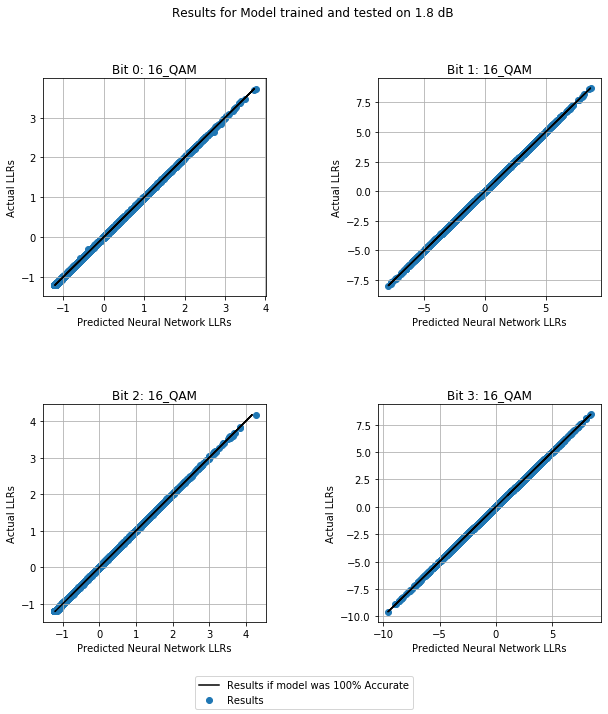

In [8]:
y_pred = [None]*num_outputs
y_pred = model.predict(X_test_single_SNR)

f = plt.figure()
f.set_figheight(10)
f.set_figwidth(10)
for i in range(num_outputs):
  if num_outputs != 1:
    predicted = y_pred[i][:]
  else:
    predicted = y_pred

  plt.subplot(2,2,i+1)
  plt.scatter(np.asarray(predicted), y_test_single_SNR[:,i].reshape([-1,1]))
  plt.plot(y_test_single_SNR[:,i].reshape([-1,1]), y_test_single_SNR[:,i].reshape([-1,1]), 'k')
  plt.xlabel("Predicted Neural Network LLRs")
  plt.ylabel("Actual LLRs")
  plt.title("Bit " + str(i) + ": " + MODULATION)
  plt.grid()

plt.subplots_adjust(wspace=0.5, hspace=0.5)
f.legend(('Results if model was 100% Accurate', 'Results', ), loc = 'lower center')
f.suptitle("Results for Model trained and tested on " + str(SNR) + " dB")
plt.show()

In [0]:
# model.save('llr_bpsk_model_single.h5', include_optimizer=False)

# !python3 keras_export/convert_model.py llr_bpsk_model_single.h5 bpsk_single.json

## Evaluate the Model on various SNR

In [10]:
y_test_flattened = [None] * num_outputs

for i in range(num_outputs):
  y_test_flattened[i] = y_test_multiple_SNR[:,i]

# Test model on the validation and test set and report results
score_test = model.evaluate(X_test_multiple_SNR, y_test_flattened, batch_size = 100, verbose=0)

print("Evaluate model on multiple SNR:")
print("---------------------------------------------------")
print("Total Loss: \t\t\t", score_test[0])
for i in range(num_outputs):
  print("Bit " + str(i) + " [Loss, MSE] is: \t\t", score_test[i+ (num_outputs != 1)], "\t, ", score_test[i+ 1 + 2*(num_outputs != 1)])

Evaluate model on multiple SNR:
---------------------------------------------------
Total Loss: 			 6.250434187833559
Bit 0 [Loss, MSE] is: 		 0.798005 	,  0.7973316
Bit 1 [Loss, MSE] is: 		 2.3258762 	,  2.3292215
Bit 2 [Loss, MSE] is: 		 0.7973316 	,  3.5742443
Bit 3 [Loss, MSE] is: 		 2.3292215 	,  22.901434


### Plot the LLRs acquired from the neural net vs actual LLRs

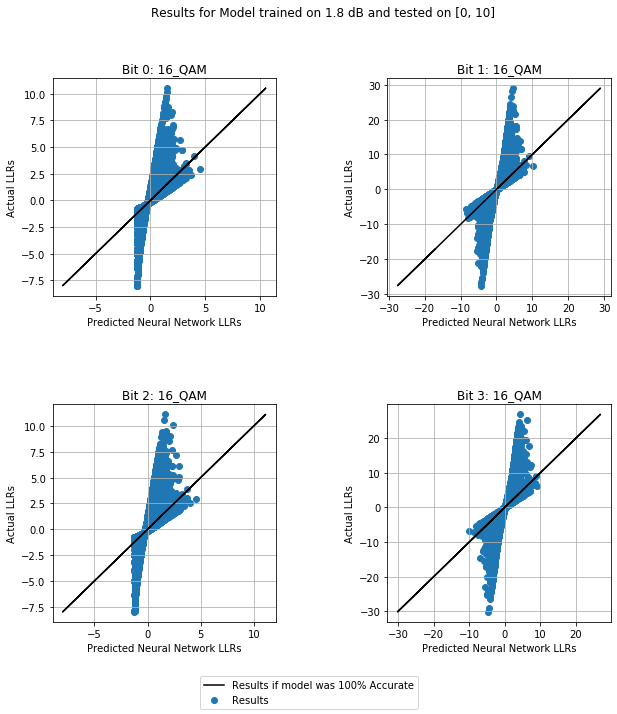

In [11]:
y_pred = [None]*num_outputs
y_pred = model.predict(X_test_multiple_SNR)

f = plt.figure()
f.set_figheight(10)
f.set_figwidth(10)
for i in range(num_outputs):
  if num_outputs != 1:
    predicted = y_pred[i][:]
  else:
    predicted = y_pred

  plt.subplot(2,2,i+1)
  plt.scatter(np.asarray(predicted), y_test_multiple_SNR[:,i].reshape([-1,1]))
  plt.plot(y_test_multiple_SNR[:,i].reshape([-1,1]), y_test_multiple_SNR[:,i].reshape([-1,1]), 'k')
  plt.xlabel("Predicted Neural Network LLRs")
  plt.ylabel("Actual LLRs")
  plt.title("Bit " + str(i) + ": " + MODULATION)
  plt.grid()

f.legend(('Results if model was 100% Accurate', 'Results', ), loc = 'lower center')
f.suptitle("Results for Model trained on " + str(SNR) + " dB" " and tested on [" + str(SNR_RANGE_MIN) + ", " + str(SNR_RANGE_MAX) + "]" )
plt.subplots_adjust(wspace=0.5, hspace=0.5)
plt.show()

# Construct Fully Connected Neural Net trained on multiple SNR

## Define the second model. Note that we have multiple outputs corresponding to each bit LLR.

In [12]:
model_input = Input(shape=(X_train_multiple_SNR.shape[1]), name='model_input')
num_outputs = y_train_multiple_SNR.shape[1]
num_layers = 6

x = Dense(128, activation='relu')(model_input)
for i in range(num_layers, 1, -1):
  x = Dense(max(num_outputs*2, 2**i), activation="relu")(x)

output_vec = [None]*num_outputs
for i in range(num_outputs):
  out_layer_name = "LLR_bit_" + str(i+1)
  bit_layer = Dense(4, activation  = 'relu', name = "bit_layer_" + str(i + 1))(x)
  output_vec[i] = Dense(1, activation = "linear", name = out_layer_name)(bit_layer)

model_multiple_snr = Model(inputs = model_input, outputs = output_vec)
model_multiple_snr.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
model_input (InputLayer)        [(None, 2)]          0                                            
__________________________________________________________________________________________________
dense_7 (Dense)                 (None, 128)          384         model_input[0][0]                
__________________________________________________________________________________________________
dense_8 (Dense)                 (None, 64)           8256        dense_7[0][0]                    
__________________________________________________________________________________________________
dense_9 (Dense)                 (None, 32)           2080        dense_8[0][0]                    
____________________________________________________________________________________________

## Train the model on multiple SNR

In [0]:
# Experimented with model parameters:
# Can choose loss function, metrics, optimizer parameters
model_multiple_snr.compile(loss='logcosh',
              optimizer = optimizers.Nadam(),
              metrics = ['mean_squared_error'])

# Since we have one output per bit, store the results of each its own list
y_train_flattened = [None] * num_outputs
y_valid_flattened = [None] * num_outputs
y_test_flattened = [None] * num_outputs

for i in range(num_outputs):
  y_train_flattened[i] = y_train_multiple_SNR[:,i]
  y_valid_flattened[i] = y_valid_multiple_SNR[:,i]
  y_test_flattened[i] = y_test_multiple_SNR[:,i]

history = model_multiple_snr.fit(X_train_multiple_SNR, y_train_flattened, validation_data=(X_valid_multiple_SNR, y_valid_flattened), batch_size=50, epochs=100, verbose = 0)

## Evaluate the model on a various SNR

In [14]:
y_valid_flattened = [None] * num_outputs
y_test_flattened = [None] * num_outputs

for i in range(num_outputs):
  y_valid_flattened[i] = y_valid_multiple_SNR[:,i]
  y_test_flattened[i] = y_test_multiple_SNR[:,i]

# Test model on the validation and test set and report results
score_val = model_multiple_snr.evaluate(X_valid_multiple_SNR, y_valid_flattened, batch_size = 100, verbose=0)
score_test = model_multiple_snr.evaluate(X_test_multiple_SNR, y_test_flattened, batch_size = 100, verbose=0)

print("Evaluate model on the validation set:")
print("---------------------------------------------------")
print("Total Loss: \t\t\t", score_val[0])
for i in range(num_outputs):
  print("Bit " + str(i) + " [Loss, MSE] is: \t\t", score_val[i+ (num_outputs != 1)], "\t, ", score_val[i+ 1 + 2*(num_outputs != 1)])

print("\n\nEvaluate model on the test set:")
print("---------------------------------------------------")
print("Total Loss: \t\t\t", score_test[0])
for i in range(num_outputs):
  print("Bit " + str(i) + " [Loss, MSE] is: \t\t", score_test[i+ (num_outputs != 1)], "\t, ", score_test[i+ 1 + 2*(num_outputs != 1)])

Evaluate model on the validation set:
---------------------------------------------------
Total Loss: 			 4.616531531016032
Bit 0 [Loss, MSE] is: 		 0.57796293 	,  0.6092434
Bit 1 [Loss, MSE] is: 		 1.871766 	,  1.8416798
Bit 2 [Loss, MSE] is: 		 0.6092434 	,  1.9490647
Bit 3 [Loss, MSE] is: 		 1.8416798 	,  13.412544


Evaluate model on the test set:
---------------------------------------------------
Total Loss: 			 4.735565575686368
Bit 0 [Loss, MSE] is: 		 0.5645975 	,  0.5655713
Bit 1 [Loss, MSE] is: 		 1.7848042 	,  1.8205925
Bit 2 [Loss, MSE] is: 		 0.5655713 	,  2.0251794
Bit 3 [Loss, MSE] is: 		 1.8205925 	,  13.385569


### Plot the LLRs acquired from the neural net vs actual LLRs`

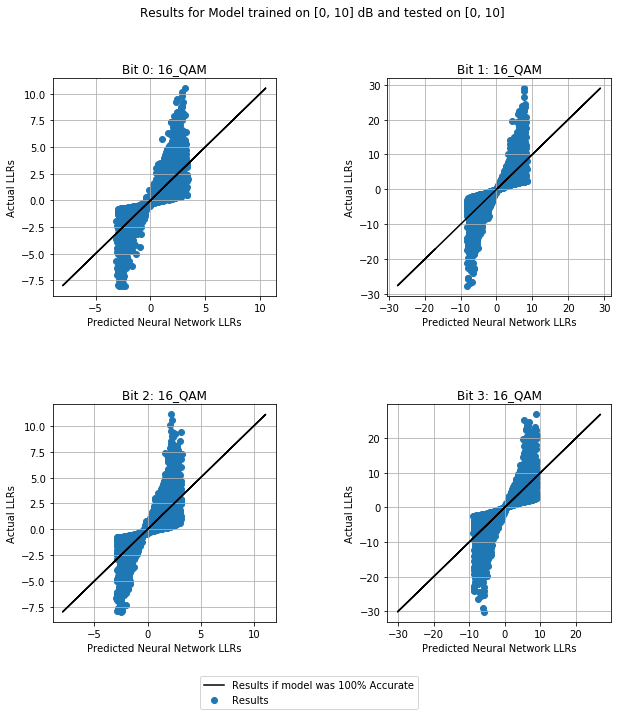

In [15]:
y_pred = [None]*num_outputs
y_pred = model_multiple_snr.predict(X_test_multiple_SNR)

f = plt.figure()
f.set_figheight(10)
f.set_figwidth(10)
for i in range(num_outputs):
  if num_outputs != 1:
    predicted = y_pred[i][:]
  else:
    predicted = y_pred

  plt.subplot(2,2,i+1)
  plt.scatter(np.asarray(predicted), y_test_multiple_SNR[:,i].reshape([-1,1]))
  plt.plot(y_test_multiple_SNR[:,i].reshape([-1,1]), y_test_multiple_SNR[:,i].reshape([-1,1]), 'k')
  plt.xlabel("Predicted Neural Network LLRs")
  plt.ylabel("Actual LLRs")
  plt.title("Bit " + str(i) + ": " + MODULATION)
  plt.grid()

f.legend(('Results if model was 100% Accurate', 'Results', ), loc = 'lower center')
f.suptitle("Results for Model trained on [" + str(SNR_RANGE_MIN) + ", " + str(SNR_RANGE_MAX) + "]" + " dB" " and tested on [" + str(SNR_RANGE_MIN) + ", " + str(SNR_RANGE_MAX) + "]" )
plt.subplots_adjust(wspace=0.5, hspace=0.5)
plt.show()

# Construct Fully Connected Nerual Net trained on Single SNR with Fading

## Define the third model. Note that we have multiple outputs corresponding to each bit LLR.

In [16]:
model_input = Input(shape=(X_train_single_SNR_fade.shape[1]), name='model_input')
num_outputs = y_train_single_SNR_fade.shape[1]
num_layers = 6

x = Dense(128, activation='relu')(model_input)
x = Dropout(0.5)(x)
for i in range(num_layers, 1, -1):
  x = Dense(max(num_outputs*2, 2**i), activation="relu")(x)

output_vec = [None]*num_outputs
for i in range(num_outputs):
  out_layer_name = "LLR_bit_" + str(i+1)
  bit_layer = Dense(4, activation  = 'relu', name = "bit_layer_" + str(i + 1))(x)
  output_vec[i] = Dense(1, activation = "linear", name = out_layer_name)(bit_layer)

model_fade = Model(inputs = model_input, outputs = output_vec)
model_fade.summary()

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
model_input (InputLayer)        [(None, 2)]          0                                            
__________________________________________________________________________________________________
dense_13 (Dense)                (None, 128)          384         model_input[0][0]                
__________________________________________________________________________________________________
dropout (Dropout)               (None, 128)          0           dense_13[0][0]                   
__________________________________________________________________________________________________
dense_14 (Dense)                (None, 64)           8256        dropout[0][0]                    
____________________________________________________________________________________________

## Train the model on faded symbols with AWGN noise

In [0]:
# Experimented with model parameters:
# Can choose loss function, metrics, optimizer parameters
model_fade.compile(loss='logcosh',
              optimizer = optimizers.Nadam(),
              metrics = ['mean_squared_error'])

# Since we have one output per bit, store the results of each its own list
y_train_flattened = [None] * num_outputs
y_valid_flattened = [None] * num_outputs
y_test_flattened = [None] * num_outputs

for i in range(num_outputs):
  y_train_flattened[i] = y_train_single_SNR_fade[:,i]
  y_valid_flattened[i] = y_valid_single_SNR_fade[:,i]
  y_test_flattened[i] = y_test_single_SNR_fade[:,i]

history = model_fade.fit(X_train_single_SNR_fade, y_train_flattened, validation_data=(X_valid_single_SNR_fade, y_valid_flattened), batch_size=50, epochs=100, verbose = 0)

## Evaluate the model on single SNR with fading

In [18]:
y_valid_flattened = [None] * num_outputs
y_test_flattened = [None] * num_outputs

for i in range(num_outputs):
  y_valid_flattened[i] = y_valid_single_SNR_fade[:,i]
  y_test_flattened[i] = y_test_single_SNR_fade[:,i]

# Test model on the validation and test set and report results
score_val = model_fade.evaluate(X_valid_single_SNR_fade, y_valid_flattened, batch_size = 100, verbose=0)
score_test = model_fade.evaluate(X_test_single_SNR_fade, y_test_flattened, batch_size = 100, verbose=0)

print("Evaluate model on the validation set:")
print("---------------------------------------------------")
print("Total Loss: \t\t\t", score_val[0])
for i in range(num_outputs):
  print("Bit " + str(i) + " [Loss, MSE] is: \t\t", score_val[i+ int(num_outputs != 1)], "\t, ", score_val[i+ 1 + 2*int(num_outputs != 1)])

print("\n\nEvaluate model on the test set:")
print("---------------------------------------------------")
print("Total Loss: \t\t\t", score_test[0])
for i in range(num_outputs):
  print("Bit " + str(i) + " [Loss, MSE] is: \t\t", score_test[i+ int(num_outputs != 1)], "\t, ", score_test[i+ 1 + 2*int(num_outputs != 1)])

Evaluate model on the validation set:
---------------------------------------------------
Total Loss: 			 0.7397337873776754
Bit 0 [Loss, MSE] is: 		 0.19354798 	,  0.08809429
Bit 1 [Loss, MSE] is: 		 0.25146192 	,  0.20662959
Bit 2 [Loss, MSE] is: 		 0.08809429 	,  0.49068308
Bit 3 [Loss, MSE] is: 		 0.20662959 	,  0.61568975


Evaluate model on the test set:
---------------------------------------------------
Total Loss: 			 0.7269990742206573
Bit 0 [Loss, MSE] is: 		 0.19760829 	,  0.08481427
Bit 1 [Loss, MSE] is: 		 0.24594508 	,  0.19863145
Bit 2 [Loss, MSE] is: 		 0.08481427 	,  0.5023234
Bit 3 [Loss, MSE] is: 		 0.19863145 	,  0.6033409


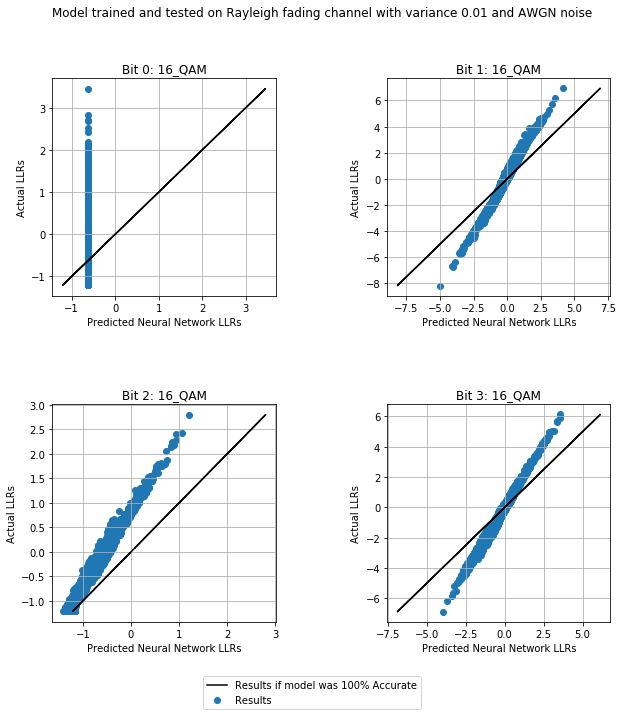

In [19]:
y_pred = [None]*num_outputs
y_pred = model_fade.predict(X_test_single_SNR_fade)

f = plt.figure()
f.set_figheight(10)
f.set_figwidth(10)
for i in range(num_outputs):
  if num_outputs != 1:
    predicted = y_pred[i][:]
  else:
    predicted = y_pred

  plt.subplot(2,2,i+1)
  plt.scatter(np.asarray(predicted), y_test_single_SNR_fade[:,i].reshape([-1,1]))
  plt.plot(y_test_single_SNR_fade[:,i].reshape([-1,1]), y_test_single_SNR_fade[:,i].reshape([-1,1]), 'k')
  plt.xlabel("Predicted Neural Network LLRs")
  plt.ylabel("Actual LLRs")
  plt.title("Bit " + str(i) + ": " + MODULATION)
  plt.grid()

f.legend(('Results if model was 100% Accurate', 'Results', ), loc = 'lower center')
f.suptitle("Model trained and tested on Rayleigh fading channel with variance " + str(FADE_VAR) + " and AWGN noise")
plt.subplots_adjust(wspace=0.5, hspace=0.5)
plt.show()